In [1]:
# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)

from code.read_sdss_fits import read_sdss_fits
from code.setup import data_home_dir

import numpy as np
from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')

# to save space the routine to read the catalog is now in code/read_data
from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];

# make some cuts to eliminate bad regimes or catastrophic failures
ilim = (vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2)

# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']

# concentration of light, Sersic index, image axis ratio b/a
cr = phot_r['petroR90']/phot_r['petroR50']; nser = mdata['n_bulge']; ba = mdata['ba_tot']; 

print "selected", np.size(zm), " after all cuts..."

# inverse Vmax
vmaxi = 1.0/vmaxm[ilim] 
# luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# Bayesian machine learning probabilities of morphological classes from Huertas-Company et al. 2011, AA 525, 157
# probaE is probability to be early type (either E or S0); 1-probaE is probability to be spiral
# probaEll = probability to be elliptical; probaS0 = p(S0); probaSab = p(Sa or Sb); probaScd = p(Sc, Sd, or Irr)
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; pSab = morph['probaSab']; pScd = morph['probaScd']; 

670722 galaxies in Meert et al. sample initially
selected 240115  after all cuts...


In [2]:
# define indices of galaxies that have the highest probability in each class
iEll = ( (pEll>pS0) & (pEll>pSab) & (pEll>pScd))
iS0  = ( (pS0>pEll) & (pS0>pSab) & (pS0>pScd))
iSab = ((pSab>pEll) & (pSab>pS0) & (pSab>pScd))
iScd = ((pScd>pEll) & (pScd>pS0) & (pScd>pSab))

mclass = np.zeros(np.shape(pE)[0], dtype = np.int); mclass_weights = np.zeros(np.shape(pE)[0], dtype = np.float)
mclass[iEll] = 1; mclass[iS0] = 2; mclass[iSab] = 3; mclass[iScd] = 4
mclass_weights[iEll] = pEll[iEll]; mclass_weights[iS0] = pS0[iS0]; 
mclass_weights[iSab] = pSab[iSab]; mclass_weights[iScd] = pScd[iScd]

# select relatively nearby galaxies which are not affected much by seeing and with clean (high prob.) class
Dmax = 200.; Mlim = -17.0
pclean = 0.7 # somewhat arbitrary definition of cleanliness...
itrain = (mclass_weights>pclean) & (phot_r['petroR50']>3.) & (Mmeert < Mlim) & (d_Lm>20.) & (d_Lm < Dmax)

# define parameters for the training sample, cr = R90/R50, ba = image axis ratio b/a
crtrain = cr[itrain]; Mtrain = Mmeert[itrain]; batrain = ba[itrain]; grtrain= grm[itrain]
mctrain = mclass[itrain]
# select a random subsample for classification
nsample = np.minimum(5000,np.size(mctrain)-1)

print "using %d galaxies as a training sample"%nsample

# get random indices
iran = np.random.randint(0.,np.size(mctrain)-1, nsample)
# classify in the space of c/a, cr, and g-r
X1 = np.column_stack((batrain[iran],crtrain[iran],grtrain[iran]))
ccol1 = np.column_stack((ba,cr,grm))

# classify using support vector classification
from sklearn.svm import SVC
classmodel1 = SVC(kernel='rbf', gamma=1.0, class_weight='auto', probability=False)

from sklearn.ensemble import RandomForestClassifier
# classify using random forest method
classmodel2 = RandomForestClassifier(n_estimators=20, max_features=2,max_depth=None, min_samples_split=1, random_state=0)

# classify using extremely randomized trees method
from sklearn.ensemble import ExtraTreesClassifier
classmodel3 = ExtraTreesClassifier(n_estimators=20, max_features=2,max_depth=None, min_samples_split=1, random_state=0)

clmethods = ['SVM','Random forest','Extremely random trees']

# not fit the models to the training sample with clean classes
classmodel1.fit(X1, mctrain[iran])
classmodel2.fit(X1, mctrain[iran])
classmodel3.fit(X1, mctrain[iran])

# assign model predicted class for each galaxy in the sample now

y_1 = classmodel1.predict(ccol1)
y_2 = classmodel2.predict(ccol1)
y_3 = classmodel3.predict(ccol1)

using 5000 galaxies as a training sample


/home/tangq/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


[588016892251078786 587735694842265713 587739376693280801
 587739132419899591 587741602576400465 587732135916142738
 588013383274004616 587735661012189247 587744873717366921]


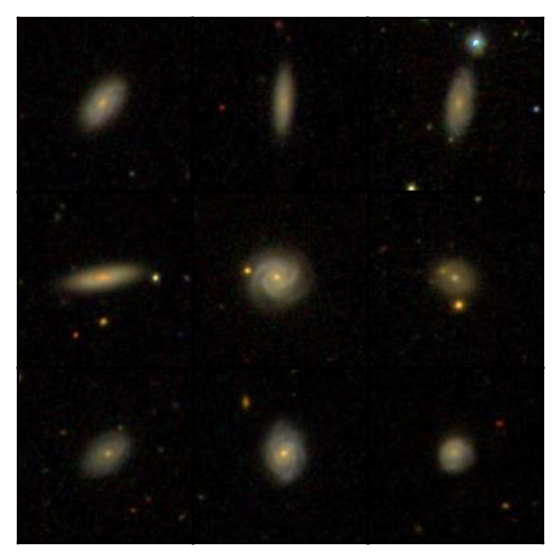

In [3]:
#Homework question 1
from code.plot_utils import sdss_img_collage

nrow = 3; ncol = 3
npix = 130
Mmw = -21.0#+/-0.38 r band absolute magnitude of mw
gr_mw = 0.682 #+/- 0.06 g-r colour of mw
R50_mw= 4 #+/-0.5 half light radius of mw
#idata = locdata[(M_rs < Mlim) & (dAl>20.) & (dAl < Dmax)]
Dmax = 200
idata = sdata[(y_2==4)& (np.abs(Mmeert - Mmw) < 0.38*2) & (np.abs(grm - gr_mw) < 0.06*2) & 
              (np.abs(phot_r['petroR50'] - R50_mw) < 0.5*2) & (d_Lm>20.) & (d_Lm < Dmax)]
iran = np.random.randint(0.,np.size(idata)-1,nrow*ncol)
dshow = idata[iran]
objs = dshow['objID']; ras = dshow['ra']; decs = dshow['dec']
print objs
sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.5)

As mentioned on Thursday, it was somewhat difficult to match Milky Way analogues when working with just the parameters originally given (Mr, g-r, and R50). Before, there were several elliptical galaxies mixed with spiral ones. When I added in assigned model predicted (for Milky Way, we want Scd which is y = 4) via supervised learning, the results were much better, giving me many late-type spiral galaxies. I do still see some early type disk and lenticular galaxies though, but no ellipticals. Between the different models (y_1, y_2, y_3, y_4) used for machine learning, I did not see too much difference in the results. I also noted that the samples seem best when I work in a range of Dmax = 200 and when I look for galaxies that fit the Milky Way parameters within 2 standard deviations. This is likely due to a larger sample generated. 

[587732590642200781 587725590920888382 587731499720638513
 587733605341266053 587730023333888334 587735666917965937
 587731680651641024 587738950959562885 587739707421819104]


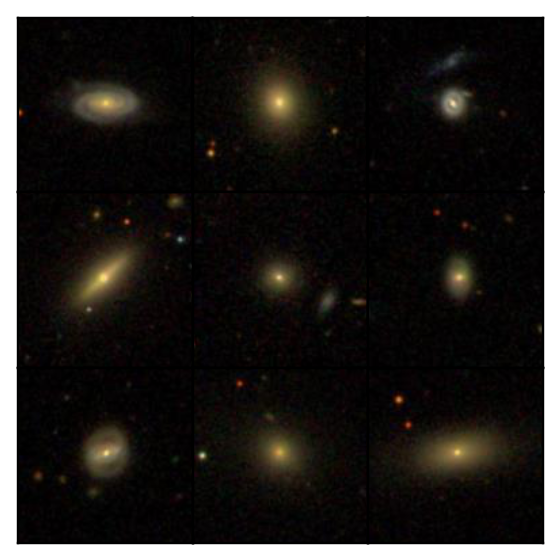

In [217]:
#Homework 3, part b
from code.plot_utils import sdss_img_collage

nrow = 3; ncol = 3
npix = 130
Mmw = -21.0#+/-0.38 r band absolute magnitude of mw
gr_mw = 0.682 #+/- 0.06 g-r colour of mw
R50_mw= 4 #+/-0.5 half light radius of mw
#idata = locdata[(M_rs < Mlim) & (dAl>20.) & (dAl < Dmax)]
Dmax = 200
cr_mw = 2.31807023149 #from below
#take error for r50 to be error for cr, as a crude approximation
crmwerr = 0.3*1.68
crdata = phot_r['petroR90']/phot_r['petroR50']
idata = sdata[(np.abs(crdata - cr_mw ) < 2*crmwerr)& (np.abs(Mmeert - Mmw) < 0.38*2) & 
              (np.abs(grm - gr_mw) < 0.06*2) & (d_Lm>20.) & (d_Lm < Dmax)]
iran = np.random.randint(0.,np.size(idata)-1,nrow*ncol)
dshow = idata[iran]
objs = dshow['objID']; ras = dshow['ra']; decs = dshow['dec']
print objs
sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.5)

The appearance of galaxies do not appear to change by much (this is not account for the machine learning classification done earlier). Very generally speaking, it does seem spiral galaxies appear more frequently in the dataset. The results do seem to improve (few elliptical galaxies appearing in samples) when it replaces Mr as  constraint. This also seems to be the case for when it replaces g-r as a constraint, with the samples largely dominated by spiral galaxies. Although there is still an improvement, it does not seem as drastic when we replace the r50 constraint with cr; there are more elliptical galaxies than when we replaced Mr and g-r.

In [218]:
#Homework 2: 
z = 0.005
d = 778 # in kpc dummy distance (distance cancels out at the end, so it doesn't matter)
M = -21.00
Rd = 3.1 #+/- 0.3kpc
r50 = 1.68*Rd
print "r50 is: " + str(r50)

#calculating the apparent magnitude of the galaxy
m = M +5*np.log10(d*1000) -5 

#solid angle in arsec^2
dOmega = np.pi*(r50/d)**2*4.25e10 #converting sr to arcsec^2 at the end

#using the formula for surface brightness in units of mag/arcsec^2
u = m +2.5*np.log10(dOmega) + 10*np.log(1+z)
uerr = 0.38 #error only depends on the absolutely luminosity in r band, everything else is taken to be exact number
print "The surface brightness of Milky Way is: " + str(u) + " mag/arcsec squared." 


r50 is: 5.208
The surface brightness of Milky Way is: 20.4470772998 mag/arcsec squared.


In [214]:
#Homework 2
gr_mw = 0.682
gr_mw_perr = 0.066
gr_mw_nerr = 0.056

b1 = 1.678

#in the calculaltion of R90, the Sigma_e cancels out from numerator and denominator, we do not need to calculate it
#Solving this on Wolframalpha (sorry, having a lot of problems with scipy quad) and integrating x*exp(-b1(x/r50-1)) 
#from 0 to inf I got
totalflux = 51.5827
from scipy.integrate import quad
from scipy.optimize import minimize
#the function, integrated, is -r50*exp(-b1(x/r50 -1))*(r50+b1*x)/b1^2, trying to solve this, we get
def func(r):
    return r*np.exp(-b1*(r/r50-1))
def gunc(r):
    return quad(func,0,r)[0]/totalflux
hunc = lambda r:np.abs(gunc(r)-0.9)
r90 = minimize(hunc, 3, method = "Nelder-Mead").x[0]
#the efunction evaluated at r=0 has the value
cr_mw = r90/r50
#take error for r50 to be error for cr, as a crude approximation
crmwerr = 0.3*1.68
print "The cr value is: " + str(cr_mw) + " +/- " + str(crmwerr)

The cr value is: 2.31807023149 +/- 0.504


670722 galaxies in Meert et al. sample initially
selected 240115  after all cuts...


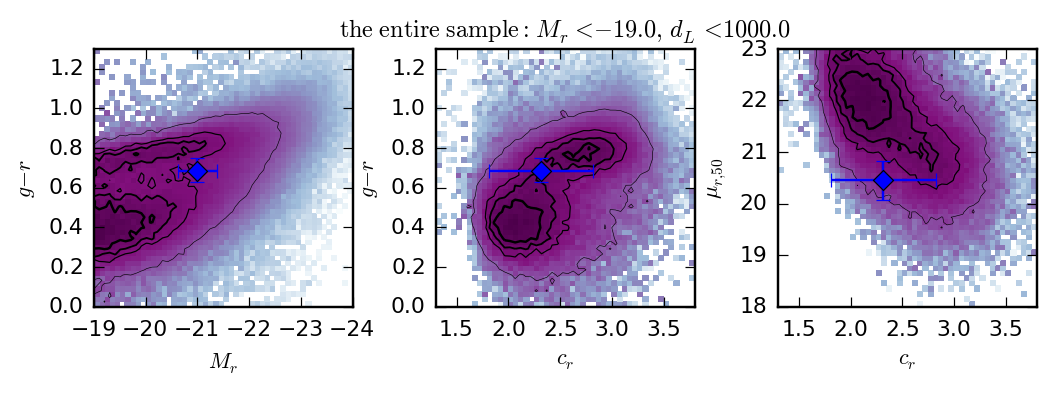

In [219]:
#Plotting stuff
import numpy as np
from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')

# to save space the routine to read the catalog is now in code/read_data
from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];

# make some cuts to eliminate bad regimes or catastrophic failures
ilim = (vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2)

# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']

# concentration of light, Sersic index, image axis ratio b/a
cr = phot_r['petroR90']/phot_r['petroR50']; nser = mdata['n_bulge']; ba = mdata['ba_tot']; 

print "selected", np.size(zm), " after all cuts..."

# inverse Vmax
vmaxi = 1.0/vmaxm[ilim] 
# luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# Bayesian machine learning probabilities of morphological classes from Huertas-Company et al. 2011, AA 525, 157
# probaE is probability to be early type (either E or S0); 1-probaE is probability to be spiral
# probaEll = probability to be elliptical; probaS0 = p(S0); probaSab = p(Sa or Sb); probaScd = p(Sc, Sd, or Irr)
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; pSab = morph['probaSab']; pScd = morph['probaScd']; 

from code.plot_utils import plot_2d_dist

# select a sample of nearby SDSS galaxies down to a given luminosity to get reasonably detailed images
Mlim = -19.0; Dmax = 1000.
ipos = ((pEll<0) | (pS0<0) | (pSab<0) | (pScd<0))
iloc = (Mmeert < Mlim) & (20. < d_Lm) & (d_Lm < Dmax) & (pEll>=0) & (pS0>=0) & (pSab>=0) & (pScd>=0) 
grmloc = grm[iloc]; Mmloc  = Mmeert[iloc]
dLl = d_Lm[iloc]; vmaxiloc = vmaxi[iloc]
crloc = cr[iloc]; murloc= sb50[iloc]

Mrlim = [-24.,Mlim]; grlim = [0.,1.3];
crlim = [1.3,3.8]; sblim = [18., 23.]

clevs = np.linspace(0.2,0.95,4)

fig, ax = plt.subplots(1,3,figsize=(6., 2.0))
fig.tight_layout()

plot_2d_dist(Mmloc, grmloc, Mrlim, grlim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$M_r$', ylabel=r'$g-r$', fig_setup=ax[0])
ax[0].errorbar(np.array([-21.00]),np.array([0.682]), ([0.056],[0.066]),0.38,  'D')

ax[1].set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f$'%(Mlim,Dmax), fontsize=10)
plot_2d_dist(crloc, grmloc, crlim, grlim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$g-r$', fig_setup=ax[1])
ax[1].errorbar(np.array([2.31807023149]),np.array([0.682]),([0.056],[0.066]),0.3*1.68, 'D')

plot_2d_dist(crloc, murloc, crlim, sblim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$\mu_{r,50}$', fig_setup=ax[2])
ax[2].errorbar(np.array([2.31807023149]),np.array([20.4470772998]),  0.38, crmwerr,'D')
#plt.savefig('fig/colcrmur.pdf',bbox_inches='tight')
plt.show()


In general, the Milky Way seems off from the main grouping of galaxies. General, it is only within 1 or 2 contours in these plots. In general, it appears that the Milky Way is somewhat more luminous than most galaxies. Its colour is right between the two main groupings of blue anad red galaxies, hovering in the middle. Its surface brightness is also quite high (lower mag/arcsec^2), likely due to the fact it was intrinisically more luminous than most galaxies.

See above for part b of homework 3

In [111]:
#Homework 4
import numpy as np
from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')

# to save space the routine to read the catalog is now in code/read_data
from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];

# make some cuts to eliminate bad regimes or catastrophic failures
ilim = (vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2)

# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']

# concentration of light, Sersic index, image axis ratio b/a
cr = phot_r['petroR90']/phot_r['petroR50']; nser = mdata['n_bulge']; ba = mdata['ba_tot']; 

print "selected", np.size(zm), " after all cuts..."

# inverse Vmax
vmaxi = 1.0/vmaxm[ilim] 
# luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# Bayesian machine learning probabilities of morphological classes from Huertas-Company et al. 2011, AA 525, 157
# probaE is probability to be early type (either E or S0); 1-probaE is probability to be spiral
# probaEll = probability to be elliptical; probaS0 = p(S0); probaSab = p(Sa or Sb); probaScd = p(Sc, Sd, or Irr)
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; pSab = morph['probaSab']; pScd = morph['probaScd']; 


670722 galaxies in Meert et al. sample initially
selected 240115  after all cuts...


selected 240115  after all cuts...
best fit Schechter parameters: phi_*=9.74e-03 [h^3 Mpc^-3 dex^-1], log10[L*/h^-2 Lsun]=10.25, alpha=-0.16
selected 240115  after all cuts...
selected 4787  after all cuts...
selected 2720  after all cuts...
selected 2660  after all cuts...


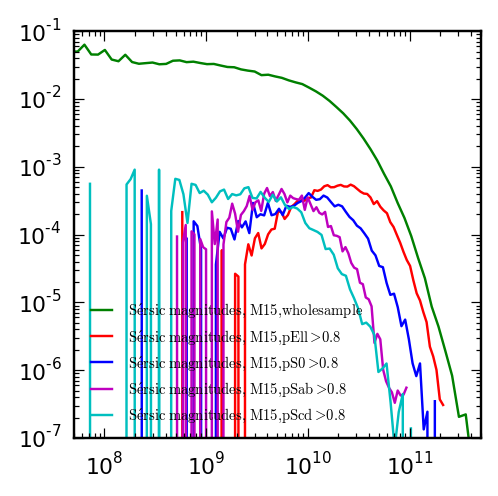

In [121]:
import numpy as np

def compute_lf_bootstrap (lum, vmi, lbins, nbootstraps = 20):
    """
    computes LF and bootstrap errors given a vector of luminosities
    lum, 1/Vmax values (vmi), and specified luminosity bins (lbins)
    """
    l_dist = np.zeros((nbootstraps, len(lbins) - 1))

    for i in range(nbootstraps):
        ind = np.random.randint(0, len(lum), len(lum))
        l_dist[i], ldbins = np.histogram(lum[ind], weights=vmi[ind], bins=lbins)

    return (l_dist.mean(0), l_dist.std(0, ddof=1))

grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']


# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.
m_min = 14.5; m_max = 17.77

# impose sample limits
size = phot_r['petroR50']
# surface brightess = -2.5log10(f/(pi*r^2))+ const
# term - 2.5*np.log10(0.5) below is to account that we are using the *half* light radius
extm = mnpdata['extinction']
mrm = phot_r['petroMag'] - extm
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])

###################FOR WHOLE GALAXY SAMPLE###############################3
ilim = (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2)

sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']


print "selected", np.size(zm), " after all cuts..."

vmaxm = mnpdata['Vmax']

d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# compute k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
#from code.calc_kcor import calc_kcor 
#ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
#kcorr = calc_kcor('r', zk, 'g - r', grm)

# absolute magnitude in the r-band corrected for extinction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;
Mmodel = phot_r['ModelMag'] - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

# 4.67 is the r-band luminosity in Lsun
Lmeert =  0.4*(4.67-(Mmeert)); Lpetrom = 0.4*(4.67-Mpetrom)
Lmodel = 0.4*(4.67-(Mmodel))
zsb = (1.+zm)*np.power(10.,0.1*(23.-sb50)) - 1.0
zsb[zsb>1] = 1.
d_Msb = cosmo.luminosityDistance(zsb)/cosmo.h/(1.+zsb)
d_Mmax[(d_Msb<d_Mmax)] = d_Msb[(d_Msb<d_Mmax)]

vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
ccm = 0.93#*(mpetrom/17)**(0.5)

solid_anglem = 4.*np.pi/3*0.195
#solid_anglem = 4681.*(np.pi/180)**2
vmaxim = vmaxim / (solid_anglem*ccm)
#vmaxim = 1.0/vmaxm/ccm

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 10; nbins = 80
phi_Lmeert, Lbins = np.histogram(Lmeert, weights=vmaxim, bins=nbins)
Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

phi_Lbsmeert, ephi_Lbsmeert = compute_lf_bootstrap(Lmeert, vmaxim, Lbins, nbootstrap)

phi_Lpetro, ephi_Lpetro = compute_lf_bootstrap(Lpetrom, vmaxim, Lbins, nbootstrap)
phi_Lmodel, ephi_Lmodel = compute_lf_bootstrap(Lmodel, vmaxim, Lbins, nbootstrap)


phi_Lbsmeert = phi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = ephi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = np.nan_to_num(ephi_Lbsmeert)

phi_Lpetro = phi_Lpetro  / dLbins / cosmo.h**3
ephi_Lpetro = ephi_Lpetro  / dLbins / cosmo.h**3
ephi_Lpetro = np.nan_to_num(ephi_Lpetro)

phi_Lmodel = phi_Lmodel  / dLbins / cosmo.h**3
ephi_Lmodel = ephi_Lmodel  / dLbins / cosmo.h**3
ephi_Lmodel = np.nan_to_num(ephi_Lmodel)

Lbinc = np.log10(10.**Lbinc*cosmo.h**2)

from scipy.optimize import curve_fit

def lf_schechter(L, phis, Lstar, alpha):
    mus = np.power(10,L)/np.power(10,Lstar)
    #print "phis, Lstar, alpha", phis, Lstar, alpha
    return np.log(10.)*phis*mus**(alpha)*np.exp(-mus)

p0 = [2.5e-3, 10.5, -0.3]
fitsel = (phi_Lbsmeert>1.e-7) & (Lbinc>8.) 
Lbfit = Lbinc[fitsel]; phi_fit = phi_Lbsmeert[fitsel]; ephi_fit = ephi_Lbsmeert[fitsel]

popt, pcov = curve_fit(lf_schechter, Lbfit, phi_fit, sigma=ephi_fit, p0 =p0, check_finite=True) 
print "best fit Schechter parameters: phi_*=%.2e [h^3 Mpc^-3 dex^-1], log10[L*/h^-2 Lsun]=%.2f, alpha=%.2f"%(popt[0],popt[1],popt[2])

import matplotlib.pyplot as plt

plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)

fig = plt.figure(figsize=(3, 3))

#plt.xlabel(r'$L_r\ (h^{-2}\, L_{\odot})$'); plt.ylabel(r'$\Phi(L_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 5e11); plt.ylim(1E-7, 0.1)
plt.xscale('log'); plt.yscale('log')
#plt.rc('font',size=11)

plt.plot(10.**Lbinc, phi_Lbsmeert, c='g', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\ M15, whole sample}$')

##########FOR ELL GALAXIES

ilimel = (pEll>0.8) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2)

sdatael = sdata[ilimel]; mdatael = mdata[ilimel]; phot_rel = phot_r[ilimel] 
mnpdatael = mnpdata[ilimel]; grmel = grm[ilimel]
zmel = sdatael['z']; mpetromel = phot_rel['petroMag']; mmeertel = mdatael['m_tot']
sb50el = sb50[ilimel]; extmel = mnpdatael['extinction']; kcorrel = mnpdatael['kcorr']


print "selected", np.size(zm), " after all cuts..."

vmaxmel = mnpdatael['Vmax']

d_Lmel = cosmo.luminosityDistance(zmel)/cosmo.h

# compute k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
#from code.calc_kcor import calc_kcor 
#ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
#kcorr = calc_kcor('r', zk, 'g - r', grm)

# absolute magnitude in the r-band corrected for extinction
Mmeertel = mmeertel - 5.0*np.log10(d_Lmel/1e-5) - extmel + 1.3*zmel - kcorrel; 
Mpetromel = mpetromel - 5.0*np.log10(d_Lmel/1e-5) - extmel + 1.3*zmel - kcorrel;
Mmodelel = phot_rel['ModelMag'] - 5.0*np.log10(d_Lmel/1e-5) - extmel + 1.3*zmel - kcorrel;

# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmaxel = 1.e-5*np.power(10.,0.2*(m_max-Mpetromel))/(1.+zmel)
d_Mminel = 1.e-5*np.power(10.,0.2*(m_min-Mpetromel))/(1.+zmel)

# 4.67 is the r-band luminosity in Lsun
Lmeertel =  0.4*(4.67-(Mmeertel))
zsbel = (1.+zmel)*np.power(10.,0.1*(23.-sb50el)) - 1.0
zsbel[zsbel>1] = 1.
d_Msbel = cosmo.luminosityDistance(zsbel)/cosmo.h/(1.+zsbel)
d_Mmaxel[(d_Msbel<d_Mmaxel)] = d_Msbel[(d_Msbel<d_Mmaxel)]

vmaximel = 1.0/(np.power(d_Mmaxel,3.0) - np.power(d_Mminel,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
ccm = 0.93#*(mpetrom/17)**(0.5)

solid_anglem = 4.*np.pi/3*0.195
#solid_anglem = 4681.*(np.pi/180)**2
vmaximel = vmaximel / (solid_anglem*ccm)
#vmaxim = 1.0/vmaxm/ccm

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 10; nbins = 80
phi_Lmeertel, Lbinsel = np.histogram(Lmeertel, weights=vmaximel, bins=nbins)
Lbincel = 0.5 * (Lbinsel[1:] + Lbinsel[:-1]); dLbinsel = (Lbinsel[1:]-Lbinsel[:-1])

phi_Lbsmeertel, ephi_Lbsmeertel = compute_lf_bootstrap(Lmeertel, vmaximel, Lbinsel, nbootstrap)

phi_Lbsmeertel = phi_Lbsmeertel  / dLbinsel / cosmo.h**3

Lbincel = np.log10(10.**Lbincel*cosmo.h**2)

plt.plot(10.**Lbincel, phi_Lbsmeertel, c='r', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\ M15, pEll>0.8}$')

##########FOR S0 GALAXIES ###############################################

ilims0 = (pS0>0.8) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2)

sdatas0 = sdata[ilims0]; mdatas0 = mdata[ilims0]; phot_rs0 = phot_r[ilims0] 
mnpdatas0 = mnpdata[ilims0]; grms0 = grm[ilims0]
zms0 = sdatas0['z']; mpetroms0 = phot_rs0['petroMag']; mmeerts0 = mdatas0['m_tot']
sb50s0 = sb50[ilims0]; extms0 = mnpdatas0['extinction']; kcorrs0 = mnpdatas0['kcorr']


print "selected", np.size(zms0), " after all cuts..."

vmaxms0 = mnpdatas0['Vmax']

d_Lms0 = cosmo.luminosityDistance(zms0)/cosmo.h

# compute k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
#from code.calc_kcor import calc_kcor 
#ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
#kcorr = calc_kcor('r', zk, 'g - r', grm)

# absolute magnitude in the r-band corrected for extinction
Mmeerts0 = mmeerts0 - 5.0*np.log10(d_Lms0/1e-5) - extms0 + 1.3*zms0 - kcorrs0; 
Mpetroms0 = mpetroms0 - 5.0*np.log10(d_Lms0/1e-5) - extms0 + 1.3*zms0 - kcorrs0;
Mmodels0 = phot_rs0['ModelMag'] - 5.0*np.log10(d_Lms0/1e-5) - extms0 + 1.3*zms0 - kcorrs0;

# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmaxs0 = 1.e-5*np.power(10.,0.2*(m_max-Mpetroms0))/(1.+zms0)
d_Mmins0 = 1.e-5*np.power(10.,0.2*(m_min-Mpetroms0))/(1.+zms0)

# 4.67 is the r-band luminosity in Lsun
Lmeerts0 =  0.4*(4.67-(Mmeerts0))
zsbs0 = (1.+zms0)*np.power(10.,0.1*(23.-sb50s0)) - 1.0
zsbs0[zsbs0>1] = 1.
d_Msbs0 = cosmo.luminosityDistance(zsbs0)/cosmo.h/(1.+zsbs0)
d_Mmaxs0[(d_Msbs0<d_Mmaxs0)] = d_Msbs0[(d_Msbs0<d_Mmaxs0)]

vmaxims0 = 1.0/(np.power(d_Mmaxs0,3.0) - np.power(d_Mmins0,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
ccm = 0.93#*(mpetrom/17)**(0.5)

solid_anglem = 4.*np.pi/3*0.195
#solid_anglem = 4681.*(np.pi/180)**2
vmaxims0 = vmaxims0 / (solid_anglem*ccm)
#vmaxim = 1.0/vmaxm/ccm

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 10; nbins = 80
phi_Lmeerts0, Lbinss0 = np.histogram(Lmeerts0, weights=vmaxims0, bins=nbins)
Lbincs0 = 0.5 * (Lbinss0[1:] + Lbinss0[:-1]); dLbinss0 = (Lbinss0[1:]-Lbinss0[:-1])

phi_Lbsmeerts0, ephi_Lbsmeerts0 = compute_lf_bootstrap(Lmeerts0, vmaxims0, Lbinss0, nbootstrap)

phi_Lbsmeerts0 = phi_Lbsmeerts0  / dLbinss0 / cosmo.h**3

Lbincs0 = np.log10(10.**Lbincs0*cosmo.h**2)

plt.plot(10.**Lbincs0, phi_Lbsmeerts0, c='b', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\ M15, pS0>0.8}$')

##########FOR Sab GALAXIES ###############################################

ilimab = (pSab>0.8) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2)

sdataab = sdata[ilimab]; mdataab = mdata[ilimab]; phot_rab = phot_r[ilimab] 
mnpdataab = mnpdata[ilimab]; grmab = grm[ilimab]
zmab = sdataab['z']; mpetromab = phot_rab['petroMag']; mmeertab = mdataab['m_tot']
sb50ab = sb50[ilimab]; extmab = mnpdataab['extinction']; kcorrab = mnpdataab['kcorr']


print "selected", np.size(zmab), " after all cuts..."

vmaxmab = mnpdataab['Vmax']

d_Lmab = cosmo.luminosityDistance(zmab)/cosmo.h

# compute k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
#from code.calc_kcor import calc_kcor 
#ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
#kcorr = calc_kcor('r', zk, 'g - r', grm)

# absolute magnitude in the r-band corrected for extinction
Mmeertab = mmeertab - 5.0*np.log10(d_Lmab/1e-5) - extmab + 1.3*zmab - kcorrab; 
Mpetromab = mpetromab - 5.0*np.log10(d_Lmab/1e-5) - extmab + 1.3*zmab - kcorrab;
Mmodelab = phot_rab['ModelMag'] - 5.0*np.log10(d_Lmab/1e-5) - extmab + 1.3*zmab - kcorrab;

# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmaxab = 1.e-5*np.power(10.,0.2*(m_max-Mpetromab))/(1.+zmab)
d_Mminab = 1.e-5*np.power(10.,0.2*(m_min-Mpetromab))/(1.+zmab)

# 4.67 is the r-band luminosity in Lsun
Lmeertab =  0.4*(4.67-(Mmeertab))
zsbab = (1.+zmab)*np.power(10.,0.1*(23.-sb50ab)) - 1.0
zsbab[zsbab>1] = 1.
d_Msbab = cosmo.luminosityDistance(zsbab)/cosmo.h/(1.+zsbab)
d_Mmaxab[(d_Msbab<d_Mmaxab)] = d_Msbab[(d_Msbab<d_Mmaxab)]

vmaximab = 1.0/(np.power(d_Mmaxab,3.0) - np.power(d_Mminab,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
ccm = 0.93#*(mpetrom/17)**(0.5)

solid_anglem = 4.*np.pi/3*0.195
#solid_anglem = 4681.*(np.pi/180)**2
vmaximab = vmaximab / (solid_anglem*ccm)
#vmaxim = 1.0/vmaxm/ccm

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 10; nbins = 80
phi_Lmeertab, Lbinsab = np.histogram(Lmeertab, weights=vmaximab, bins=nbins)
Lbincab = 0.5 * (Lbinsab[1:] + Lbinsab[:-1]); dLbinsab = (Lbinsab[1:]-Lbinsab[:-1])

phi_Lbsmeertab, ephi_Lbsmeertab = compute_lf_bootstrap(Lmeertab, vmaximab, Lbinsab, nbootstrap)

phi_Lbsmeertab = phi_Lbsmeertab  / dLbinsab / cosmo.h**3

Lbincab = np.log10(10.**Lbincab*cosmo.h**2)

plt.plot(10.**Lbincab, phi_Lbsmeertab, c='m', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\ M15, pSab>0.8}$')

##########FOR Scd GALAXIES ###############################################

ilimcd = (pScd>0.8) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2)

sdatacd = sdata[ilimcd]; mdatacd = mdata[ilimcd]; phot_rcd = phot_r[ilimcd] 
mnpdatacd = mnpdata[ilimcd]; grmcd = grm[ilimcd]
zmcd = sdatacd['z']; mpetromcd = phot_rcd['petroMag']; mmeertcd = mdatacd['m_tot']
sb50cd = sb50[ilimcd]; extmcd = mnpdatacd['extinction']; kcorrcd = mnpdatacd['kcorr']


print "selected", np.size(zmcd), " after all cuts..."

vmaxmcd = mnpdatacd['Vmax']

d_Lmcd = cosmo.luminosityDistance(zmcd)/cosmo.h

# compute k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
#from code.calc_kcor import calc_kcor 
#ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
#kcorr = calc_kcor('r', zk, 'g - r', grm)

# absolute magnitude in the r-band corrected for extinction
Mmeertcd = mmeertcd - 5.0*np.log10(d_Lmcd/1e-5) - extmcd + 1.3*zmcd - kcorrcd; 
Mpetromcd = mpetromcd - 5.0*np.log10(d_Lmcd/1e-5) - extmcd + 1.3*zmcd - kcorrcd;
Mmodelcd = phot_rcd['ModelMag'] - 5.0*np.log10(d_Lmcd/1e-5) - extmcd + 1.3*zmcd - kcorrcd;

# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmaxcd = 1.e-5*np.power(10.,0.2*(m_max-Mpetromcd))/(1.+zmcd)
d_Mmincd = 1.e-5*np.power(10.,0.2*(m_min-Mpetromcd))/(1.+zmcd)

# 4.67 is the r-band luminosity in Lsun
Lmeertcd =  0.4*(4.67-(Mmeertcd))
zsbcd = (1.+zmcd)*np.power(10.,0.1*(23.-sb50cd)) - 1.0
zsbcd[zsbcd>1] = 1.
d_Msbcd = cosmo.luminosityDistance(zsbcd)/cosmo.h/(1.+zsbcd)
d_Mmaxcd[(d_Msbcd<d_Mmaxcd)] = d_Msbcd[(d_Msbcd<d_Mmaxcd)]

vmaximcd = 1.0/(np.power(d_Mmaxcd,3.0) - np.power(d_Mmincd,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
ccm = 0.93#*(mpetrom/17)**(0.5)

solid_anglem = 4.*np.pi/3*0.195
#solid_anglem = 4681.*(np.pi/180)**2
vmaximcd = vmaximcd / (solid_anglem*ccm)
#vmaxim = 1.0/vmaxm/ccm

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 10; nbins = 80
phi_Lmeertcd, Lbinscd = np.histogram(Lmeertcd, weights=vmaximcd, bins=nbins)
Lbinccd = 0.5 * (Lbinscd[1:] + Lbinscd[:-1]); dLbinscd = (Lbinscd[1:]-Lbinscd[:-1])

phi_Lbsmeertcd, ephi_Lbsmeertcd = compute_lf_bootstrap(Lmeertcd, vmaximcd, Lbinscd, nbootstrap)

phi_Lbsmeertcd = phi_Lbsmeertcd  / dLbinscd / cosmo.h**3

Lbinccd = np.log10(10.**Lbinccd*cosmo.h**2)

plt.plot(10.**Lbinccd, phi_Lbsmeertcd, c='c', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\ M15, pScd>0.8}$')

plt.legend(loc='best', fontsize=6, frameon=False)

plt.show()

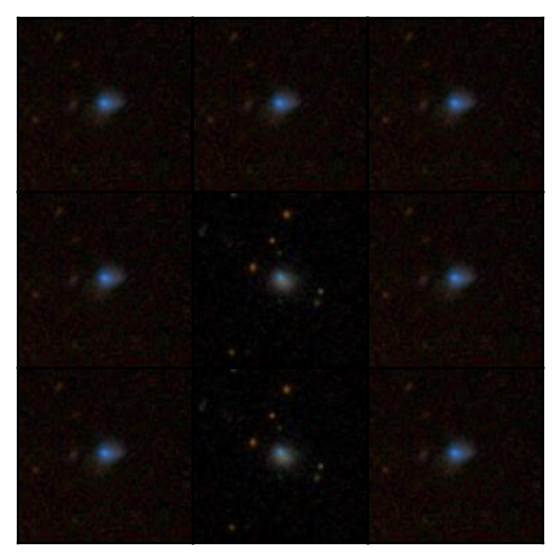

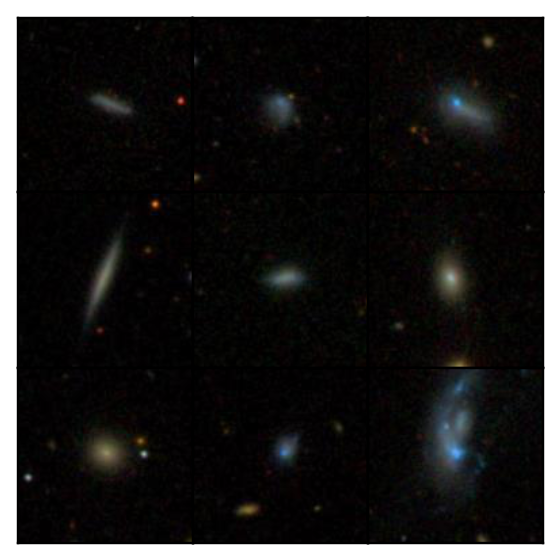

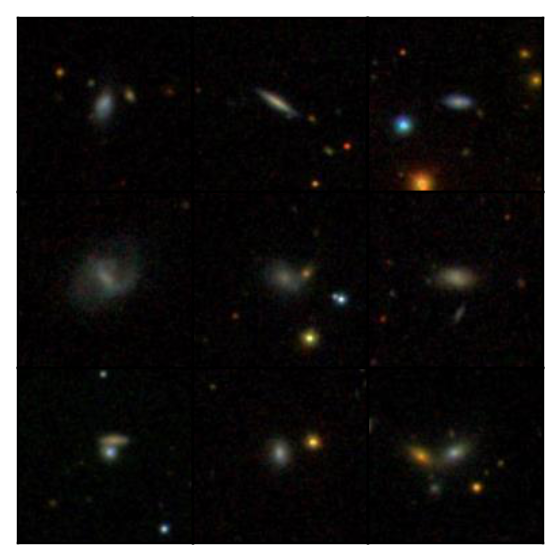

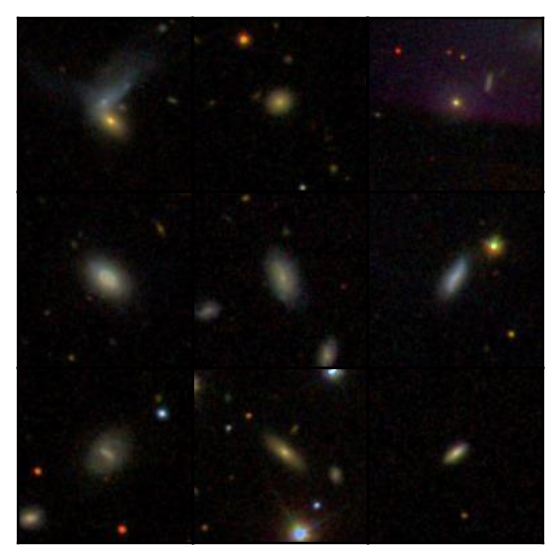

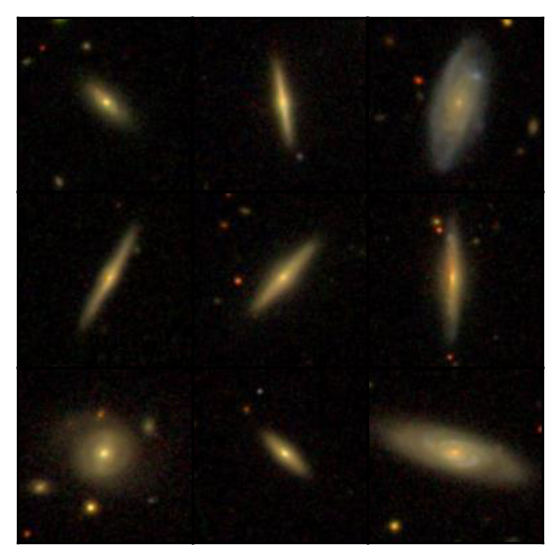

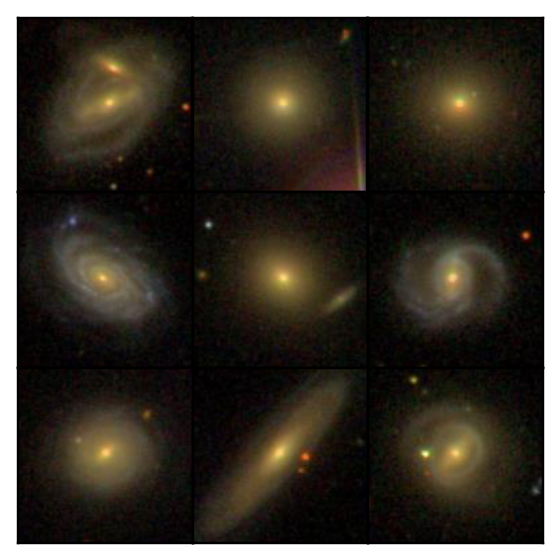

In [199]:
#Homework 4b
from code.plot_utils import sdss_img_collage

nrow = 3; ncol = 3
npix = 130

Dmax = 200.; Mlim = -19.0
#midLbin = np.mean(Lbins[20], Lbins[19])
for i in range(6):
    rdata = sdata[(Lmeert > Lbins[i*10]) & (Lmeert < Lbins[i*10+1]) & (d_Lm>20.) & (d_Lm < Dmax)]
    iran = np.random.randint(0.,np.size(rdata)-1,nrow*ncol)
    dshow = rdata[iran]
    objs = dshow['objid']; ras = dshow['ra']; decs = dshow['dec']
    sdss_img_collage(objs,ras,decs, nrow, ncol, npix, scale=0.5)
    plt.clf()